In [15]:
from brian2 import *
import numpy as np

In [16]:
N = 1
v_r = -70*mV # reset voltage
v_th = -55*mV  # threshold voltage
E_l = -90*mV
dia = 20*um
length = 20*um
SA = (2*pi*(dia/2)*length) # units are um2
gL = 1*psiemens/um2 * SA # units are psiemens
C_mem = 10e-6*farad/cm2 * SA # units are farad
E_ex = 0*mV
E_i = -80*mV 
v_c = 0*mV
I_c = 1000*pamp # same as I_ext, units pamp
tau_ge = 2*ms
tau_gi_c = 6.8*ms # units of ms
integ_method = 'heun'
run_time = 100*ms

model_0 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gi*(v - E_i) + gL*(v - E_l) + I) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
dgi/dt = -gi/tau_gi : siemens
I : ampere
tau_gi : second
'''

model_1 = '''
dv/dt = (1/C_mem)*(gL*(v - E_l) + I) : volt (unless refractory)
I : ampere
'''

model_2 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gL*(v - E_l) + I) : volt (unless refractory)
ge: siemens
I : ampere
'''

In [ ]:
G1 = NeuronGroup(N, model_1, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G1.I = I_c
statemon1 = StateMonitor(G1, variables='v',record=0)

G2 = NeuronGroup(N, model_1, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G2.I = I_c
statemon2 = StateMonitor(G2, variables='v',record=0)

# if there is no synaptic delay both neurons spike at the same time and because neuron 2 is undergoing a refractory period
# at that instant, the synaptic weight from neuron 1 will not change neuron2's voltage
# having poisson input would also fix it because it makes neurons spike at different times
S0 = Synapses(G1, G2, 'w : volt', on_pre='v_post += w',delay=50*ms)
S0.connect(i=0, j=0)
# positive weight for an excitatory connection, -ve weight for inhibitory
S0.w = -0.5*mV

run(run_time)

In [17]:
G1 = NeuronGroup(N, model_0, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G1.I = I_c
G1.tau_gi = tau_gi_c
statemon1 = StateMonitor(G1, variables='v',record=0)

G2 = NeuronGroup(N, model_0, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G2.I = I_c
G2.tau_gi = tau_gi_c
statemon2 = StateMonitor(G2, variables='v',record=0)

# if there is no synaptic delay both neurons spike at the same time and because neuron 2 is undergoing a refractory period
# at that instant, the synaptic weight from neuron 1 will not change neuron2's voltage
# having poisson input would also fix it because it makes neurons spike at different times
S0 = Synapses(G1, G2, 'w : volt', on_pre='v_post += w',delay=15*ms)
S0.connect(i=0, j=0)
# positive weight for an excitatory connection, -ve weight for inhibitory
S0.w = 0.5*mV

run(run_time)

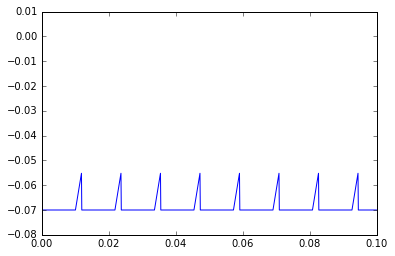

In [18]:
plot(statemon1.t,np.transpose(statemon1.v))

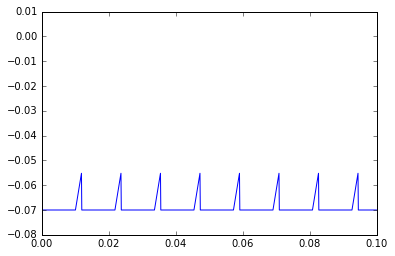

In [19]:
plot(statemon2.t,np.transpose(statemon2.v))

In [ ]:
# implementing conductance in the synapse equations
# https://brian2.readthedocs.io/en/stable/user/synapses.html?highlight=synapses#summed-variables

G3 = NeuronGroup(N, model_2, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G3.I = I_c
statemon3 = StateMonitor(G3, variables='v',record=0)

G4 = NeuronGroup(N, model_2, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G4.I = I_c
statemon4 = StateMonitor(G4, variables='v',record=0)

S3 = Synapses(G3, G4, 
              model ='''w : volt
              dge_syn/dt = -ge_syn/tau_ge : siemens
              ge_post=ge_syn: siemens''', on_pre='v_post += w',delay=50*ms)
S3.connect(i=0, j=0)
# positive weight for an excitatory connection, -ve weight for inhibitory
S3.w = 0.5*volt

In [ ]:
plot(statemon3.t,np.transpose(statemon3.v))

In [ ]:
plot(statemon4.t,np.transpose(statemon4.v))

In [ ]:
neurons = NeuronGroup(1, model='''dv/dt=(gtot-v)/(10*ms) : 1
                                  gtot : 1''')
S = Synapses(input, neurons,
             model='''dg/dt=-a*g+b*x*(1-g) : 1
                      gtot_post = g : 1  (summed)
                      dx/dt=-c*x : 1
                      w : 1 # synaptic weight''', on_pre='x+=w')